In [12]:
# ============================================================
# 1. IMPOR PUSTAKA YANG DIBUTUHKAN
# ============================================================
import os

# Menyembunyikan log TensorFlow yang berlebihan
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import json
from scipy.signal import butter, filtfilt
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Menonaktifkan pesan log dari TensorFlow & Python agar output bersih
tf.get_logger().setLevel(logging.ERROR)

# ============================================================
# 2. PERSIAPAN DIREKTORI UNTUK KASUS E
# ============================================================
print("🚀 Membuat direktori untuk Kasus E (Klasifikasi Gerakan)...")

os.makedirs("saved_models_kasus_e", exist_ok=True)
os.makedirs("tflite_models_kasus_e_float", exist_ok=True)
os.makedirs("tflite_models_kasus_e_int8", exist_ok=True)
os.makedirs("headers_kasus_e_float", exist_ok=True)
os.makedirs("headers_kasus_e_int8", exist_ok=True)

print("✅ Direktori siap untuk Kasus E – pipeline TinyML gerakan tubuh.")

🚀 Membuat direktori untuk Kasus E (Klasifikasi Gerakan)...
✅ Direktori siap untuk Kasus E – pipeline TinyML gerakan tubuh.


In [13]:
def aug_jitter(x, sigma=0.02, rng=None):
    # x: (100, 6)
    rng = rng or np.random.default_rng()
    noise = rng.normal(0.0, sigma, size=x.shape).astype(np.float32)
    return (x + noise).astype(np.float32)

def aug_scaling(x, sigma=0.10, rng=None):
    # skala per-channel (6 kanal), dekat 1.0
    rng = rng or np.random.default_rng()
    scale = rng.normal(1.0, sigma, size=(1, x.shape[1])).astype(np.float32)
    return (x * scale).astype(np.float32)

def aug_bias(x, sigma=0.02, rng=None):
    # bias per-channel kecil
    rng = rng or np.random.default_rng()
    bias = rng.normal(0.0, sigma, size=(1, x.shape[1])).astype(np.float32)
    return (x + bias).astype(np.float32)

def aug_time_shift(x, max_shift=5, rng=None):
    # geser 0..max_shift sampel (50 Hz → 5 sampel = 0.1 detik)
    rng = rng or np.random.default_rng()
    shift = int(rng.integers(-max_shift, max_shift + 1))
    if shift == 0:
        return x
    y = np.empty_like(x)
    if shift > 0:
        y[:shift] = x[0:1]          # padding pakai nilai awal
        y[shift:] = x[:-shift]
    else:
        s = -shift
        y[-s:] = x[-1:]             # padding pakai nilai akhir
        y[:-s] = x[s:]
    return y.astype(np.float32)

def aug_dropout(x, drop_prob=0.02, rng=None):
    # nol-kan sebagian kecil titik data
    rng = rng or np.random.default_rng()
    mask = rng.random(size=x.shape) < drop_prob
    y = x.copy()
    y[mask] = 0.0
    return y.astype(np.float32)

def augment_train_set(X_train, y_train, copies=1, seed=123):
    """
    copies=1 → setiap sampel train dibuat 1 versi augment tambahan.
    Output: X_train_aug, y_train_aug (train membesar).
    """
    rng = np.random.default_rng(seed)
    aug_funcs = [aug_jitter, aug_scaling, aug_bias, aug_time_shift, aug_dropout]

    X_out = [X_train]
    y_out = [y_train]

    for _ in range(copies):
        X_new = np.empty_like(X_train)
        for i in range(len(X_train)):
            x = X_train[i]
            # pilih 2 augmentasi acak agar variasi lebih kuat tapi masih realistis
            f1 = aug_funcs[int(rng.integers(0, len(aug_funcs)))]
            f2 = aug_funcs[int(rng.integers(0, len(aug_funcs)))]
            x_aug = f2(f1(x, rng=rng), rng=rng)
            X_new[i] = x_aug
        X_out.append(X_new)
        y_out.append(y_train.copy())

    X_aug = np.concatenate(X_out, axis=0).astype(np.float32)
    y_aug = np.concatenate(y_out, axis=0)
    return X_aug, y_aug


In [21]:
# ---------- Konfigurasi ----------
FILES = {
    "idle": "idle_0002.csv",
    "walk": "walk_0003.csv",
    "jog":  "jog_0005.csv",
}

SR_HZ        = 50
WINDOW_SEC   = 2.0
WINDOW_SIZE  = int(WINDOW_SEC * SR_HZ)   # 100 sampel
STEP         = WINDOW_SIZE               # TANPA overlap (0-2, 2-4, 4-6, dst)

LPF_CUTOFF_HZ= 5.0
LPF_ORDER    = 4
SENSOR_COLS  = ["accX","accY","accZ","gyroX","gyroY","gyroZ"]

# jumlah tetap per kelas
N_TEST_PER_CLASS = 30
N_VAL_PER_CLASS  = 40   # ubah sesuai kebutuhan
SEED_SPLIT       = 42

# ---------- Low-pass filter (offline) ----------
def butter_lowpass_filter(series, cutoff=LPF_CUTOFF_HZ, fs=SR_HZ, order=LPF_ORDER):
    b, a = butter(order, cutoff / (0.5 * fs), btype="low")
    return filtfilt(b, a, series)

# ---------- 1) Load CSV per aktivitas + low-pass per file ----------
data_by_label = {}  # label -> np.array [N, 6]
raw_counts = {}

for label, path in FILES.items():
    df = pd.read_csv(path, comment="#")
    raw_counts[label] = len(df)

    arr = df[SENSOR_COLS].to_numpy(np.float32)

    # low-pass filter per kolom, per file
    for i in range(arr.shape[1]):
        arr[:, i] = butter_lowpass_filter(arr[:, i])

    data_by_label[label] = arr

print(f"Total data mentah: {sum(raw_counts.values())} sampel dari {len(FILES)} aktivitas.")
for k in raw_counts:
    print(f"   {k:<5}: {raw_counts[k]} sampel")

# ---------- 2) Potong menjadi segmen 2 detik TANPA overlap ----------
segments_by_label = {}  # label -> list of segments [WINDOW_SIZE, 6]
for label, arr in data_by_label.items():
    segs = []
    n = len(arr)
    for start in range(0, n - WINDOW_SIZE + 1, STEP):
        segs.append(arr[start:start + WINDOW_SIZE])
    segments_by_label[label] = segs
    print(f"Total segmen {label:<5}: {len(segs)} (masing-masing {WINDOW_SIZE} sampel)")

# ---------- 3) Split seimbang per kelas: test 30 / val 10 / sisanya train ----------
rng = np.random.default_rng(SEED_SPLIT)

X_train_list, y_train_list = [], []
X_val_list,   y_val_list   = [], []
X_test_list,  y_test_list  = [], []

for label, segs in segments_by_label.items():
    n_seg = len(segs)
    need = N_TEST_PER_CLASS + N_VAL_PER_CLASS
    if n_seg < need:
        raise ValueError(
            f"Segmen untuk kelas '{label}' tidak cukup: ada {n_seg}, butuh minimal {need} "
            f"(test={N_TEST_PER_CLASS} + val={N_VAL_PER_CLASS})."
        )

    idx = np.arange(n_seg)
    rng.shuffle(idx)

    test_idx  = idx[:N_TEST_PER_CLASS]
    val_idx   = idx[N_TEST_PER_CLASS:N_TEST_PER_CLASS + N_VAL_PER_CLASS]
    train_idx = idx[N_TEST_PER_CLASS + N_VAL_PER_CLASS:]

    for i in train_idx:
        X_train_list.append(segs[i])
        y_train_list.append(label)
    for i in val_idx:
        X_val_list.append(segs[i])
        y_val_list.append(label)
    for i in test_idx:
        X_test_list.append(segs[i])
        y_test_list.append(label)


X_train = np.array(X_train_list, np.float32)
X_val   = np.array(X_val_list,   np.float32)
X_test  = np.array(X_test_list,  np.float32)

y_train = np.array(y_train_list)
y_val   = np.array(y_val_list)
y_test  = np.array(y_test_list)

print("\n✅ Split selesai (tanpa overlap, test seimbang, tanpa StandardScaler):")
print(f"   X_train: {X_train.shape} | X_val: {X_val.shape} | X_test: {X_test.shape}")

# ---------- 4) Label encode ----------
le = LabelEncoder()
le.fit(np.concatenate([y_train, y_val, y_test], axis=0))

y_train_enc = le.transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

# ---------- 5) Acak urutan dalam tiap subset ----------
X_train, y_train_enc = shuffle(X_train, y_train_enc, random_state=1)
X_train, y_train_enc = augment_train_set(X_train, y_train_enc, copies=1, seed=2026)
X_val,   y_val_enc   = shuffle(X_val,   y_val_enc,   random_state=2)
X_test,  y_test_enc  = shuffle(X_test,  y_test_enc,  random_state=3)

# ---------- 6) StandardScaler berdasarkan train set ----------
scaler = StandardScaler()
Xtr2d = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(Xtr2d)

def apply_scale(X):
    X2d = X.reshape(-1, X.shape[-1])
    return scaler.transform(X2d).reshape(X.shape).astype(np.float32)

X_train = apply_scale(X_train)
X_val   = apply_scale(X_val)
X_test  = apply_scale(X_test)

# ---------- Rekap per kelas ----------
print("\n📌 Rekap jumlah per kelas:")
for cls, name in enumerate(le.classes_):
    print(f"   {name:<5} | train={np.sum(y_train_enc==cls):4d} | val={np.sum(y_val_enc==cls):3d} | test={np.sum(y_test_enc==cls):3d}")

print("\nFinal shapes:")
print(f"   X_train: {X_train.shape}, y_train: {y_train_enc.shape}")
print(f"   X_val:   {X_val.shape},   y_val:   {y_val_enc.shape}")
print(f"   X_test:  {X_test.shape},  y_test:  {y_test_enc.shape}")

# ---------- Simpan ----------
np.save("X_train.npy", X_train)
np.save("X_val.npy",   X_val)
np.save("X_test.npy",  X_test)
np.save("y_train.npy", y_train_enc)
np.save("y_val.npy",   y_val_enc)
np.save("y_test.npy",  y_test_enc)

with open("preprocess_meta_kasuse.json","w") as f:
    json.dump({
        "sr_hz": SR_HZ,
        "window_sec": WINDOW_SEC,
        "window_size": WINDOW_SIZE,
        "step": STEP,
        "lpf_cutoff_hz": LPF_CUTOFF_HZ,
        "lpf_order": LPF_ORDER,
        "feature_order": SENSOR_COLS,
        "test_per_class": N_TEST_PER_CLASS,
        "val_per_class": N_VAL_PER_CLASS,
        "normalization": "none"
    }, f, indent=2)

with open("label_mapping_kasuse.json","w") as f:
    # id -> nama kelas
    json.dump({int(i): cls for i, cls in enumerate(le.classes_)}, f, indent=2)

print("\n💾 Dataset disimpan:")
print("   - X_train.npy, X_val.npy, X_test.npy")
print("   - y_train.npy, y_val.npy, y_test.npy")
print("   - preprocess_meta_kasuse.json, label_mapping_kasuse.json")


Total data mentah: 45000 sampel dari 3 aktivitas.
   idle : 15000 sampel
   walk : 15000 sampel
   jog  : 15000 sampel
Total segmen idle : 150 (masing-masing 100 sampel)
Total segmen walk : 150 (masing-masing 100 sampel)
Total segmen jog  : 150 (masing-masing 100 sampel)

✅ Split selesai (tanpa overlap, test seimbang, tanpa StandardScaler):
   X_train: (240, 100, 6) | X_val: (120, 100, 6) | X_test: (90, 100, 6)
Label mapping: {'idle': 0, 'jog': 1, 'walk': 2}

📌 Rekap jumlah per kelas:
   idle  | train= 160 | val= 40 | test= 30
   jog   | train= 160 | val= 40 | test= 30
   walk  | train= 160 | val= 40 | test= 30

Final shapes:
   X_train: (480, 100, 6), y_train: (480,)
   X_val:   (120, 100, 6),   y_val:   (120,)
   X_test:  (90, 100, 6),  y_test:  (90,)

💾 Dataset disimpan:
   - X_train.npy, X_val.npy, X_test.npy
   - y_train.npy, y_val.npy, y_test.npy
   - preprocess_meta_kasuse.json, label_mapping_kasuse.json


In [25]:
# ============================================================
# 4. TRAINING, EVALUASI, DAN PENGUMPULAN HASIL (Kasus E)
# ============================================================

print("\n🚀 Memuat dataset window (X_*, y_*)...\n")

# --- Load data dari preprocessing ---
X_train = np.load("X_train.npy")
X_val   = np.load("X_val.npy")
X_test  = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_val   = np.load("y_val.npy")
y_test  = np.load("y_test.npy")

num_classes = len(np.unique(y_train))
print(f"Dataset siap: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}, Classes={num_classes}")

# Flatten karena MLP (tanpa CNN/RNN)
x_train = X_train.reshape(X_train.shape[0], -1)
x_val   = X_val.reshape(X_val.shape[0], -1)
x_test  = X_test.reshape(X_test.shape[0], -1)

# One-hot encoding untuk output softmax
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val   = tf.keras.utils.to_categorical(y_val, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

# ------------------------------------------------------------
# Konfigurasi model: (jumlah hidden layer, jumlah neuron/layer)
# ------------------------------------------------------------
model_configs = [(1, 8), (2, 16), (3, 32), (4, 64)]

# Penampung hasil
all_train_loss_histories, all_val_loss_histories = [], []
all_test_loss_histories = []  # <-- simpan history loss pada test per epoch
all_best_val_losses, all_test_losses = [], []
all_best_val_accuracies, all_test_accuracies = [], []
all_precisions, all_recalls, all_f1s = [], [], []
all_best_epochs, model_labels = [], []

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=30, restore_best_weights=True, verbose=1
)

# Callback untuk mencatat test loss tiap epoch
class TestLossHistory(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        super().__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.test_losses = []
    def on_epoch_end(self, epoch, logs=None):
        loss_acc = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        # evaluate returns [loss, ...]; simpan loss
        self.test_losses.append(loss_acc[0])

print("\n🚀 Memulai training semua model Multikelas (Dengan Early Stopping)...\n")

for idx, (num_layers, neurons) in enumerate(model_configs, start=1):
    print(f"--- Memproses Model {idx} ({num_layers}L, {neurons}N) ---")

    # Buat model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(x_train.shape[1],)))
    model.add(tf.keras.layers.BatchNormalization())

    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))

    # Output softmax (multiclass)
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callback khusus untuk test loss history
    test_history_cb = TestLossHistory(x_test, y_test)

    # Train
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping, test_history_cb],
        verbose=0
    )

    # Simpan model
    model_path = f"saved_models_kasus_e/model_{idx}_{num_layers}L_{neurons}N.keras"
    model.save(model_path)

    # Epoch terbaik
    best_epoch_index = np.argmin(history.history['val_loss'])
    all_train_loss_histories.append(history.history['loss'])
    all_val_loss_histories.append(history.history['val_loss'])
    all_test_loss_histories.append(test_history_cb.test_losses)  # <-- simpan history test loss
    all_best_epochs.append(best_epoch_index + 1)

    # Evaluasi di val & test
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    # Prediksi & metrik
    y_pred_prob = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall    = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1        = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Simpan hasil
    all_best_val_losses.append(val_loss)
    all_best_val_accuracies.append(val_acc)
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_acc)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

    model_labels.append(f"Model {idx}\n({num_layers}L, {neurons}N)")

    # Ringkasan hasil tiap model
    print(f"  Akurasi Validasi: {val_acc*100:.2f}%")
    print(f"  Akurasi Test:     {test_acc*100:.2f}%")
    print(f"  Precision (W):    {precision*100:.2f}%")
    print(f"  Recall (W):       {recall*100:.2f}%")
    print(f"  F1-Score (W):     {f1*100:.2f}%")
    print(f"  Loss Test:        {test_loss:.4f}")
    print("-" * 50)

print("\n🏁 Pengumpulan Data Selesai.\n")


🚀 Memuat dataset window (X_*, y_*)...

Dataset siap: Train=(480, 100, 6), Val=(120, 100, 6), Test=(90, 100, 6), Classes=3

🚀 Memulai training semua model Multikelas (Dengan Early Stopping)...

--- Memproses Model 1 (1L, 8N) ---
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 20.
  Akurasi Validasi: 95.83%
  Akurasi Test:     95.56%
  Precision (W):    95.56%
  Recall (W):       95.56%
  F1-Score (W):     95.56%
  Loss Test:        0.1094
--------------------------------------------------
--- Memproses Model 2 (2L, 16N) ---
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 17.
  Akurasi Validasi: 96.67%
  Akurasi Test:     96.67%
  Precision (W):    96.77%
  Recall (W):       96.67%
  F1-Score (W):     96.66%
  Loss Test:        0.1082
--------------------------------------------------
--- Memproses Model 3 (3L, 32N) ---
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 11.
  Akurasi Validasi


📊 Membuat 5 plot untuk menganalisis hasil Kasus E...



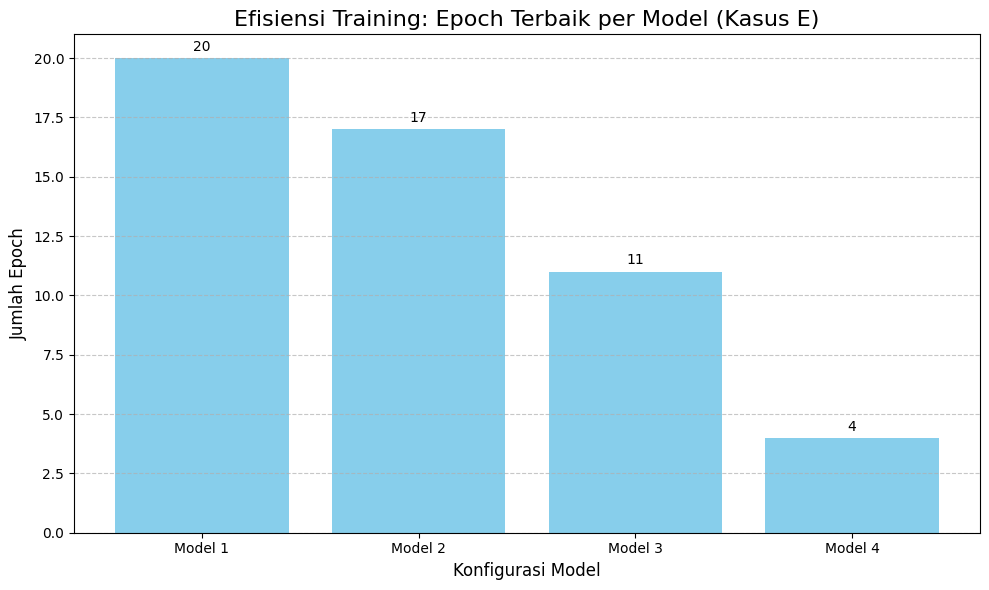

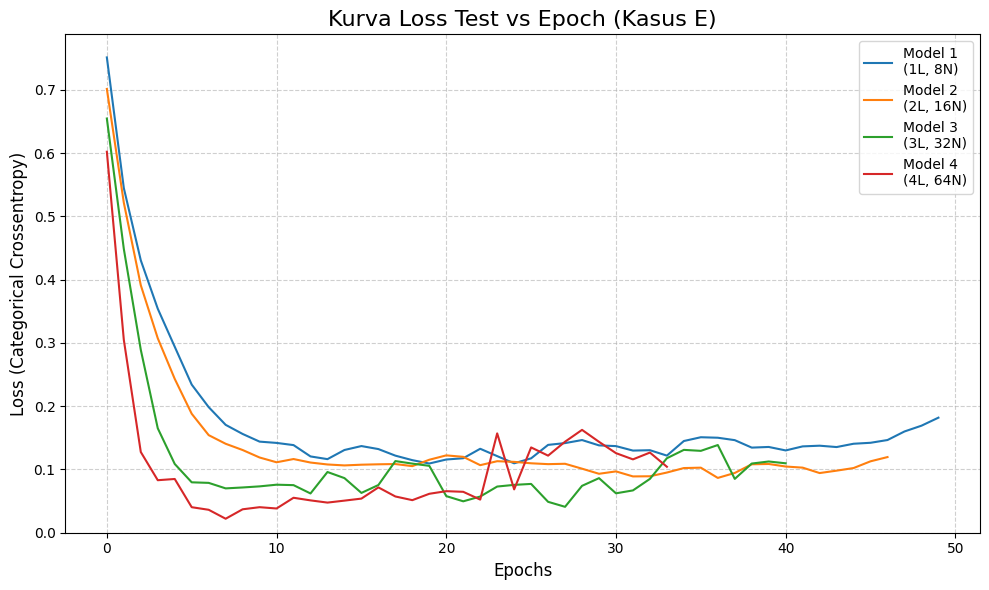

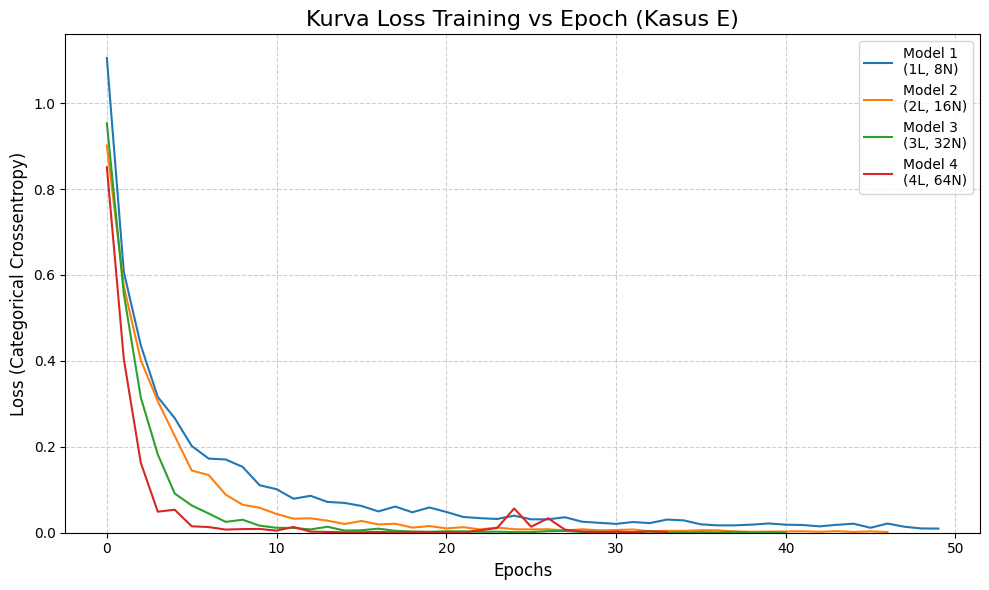

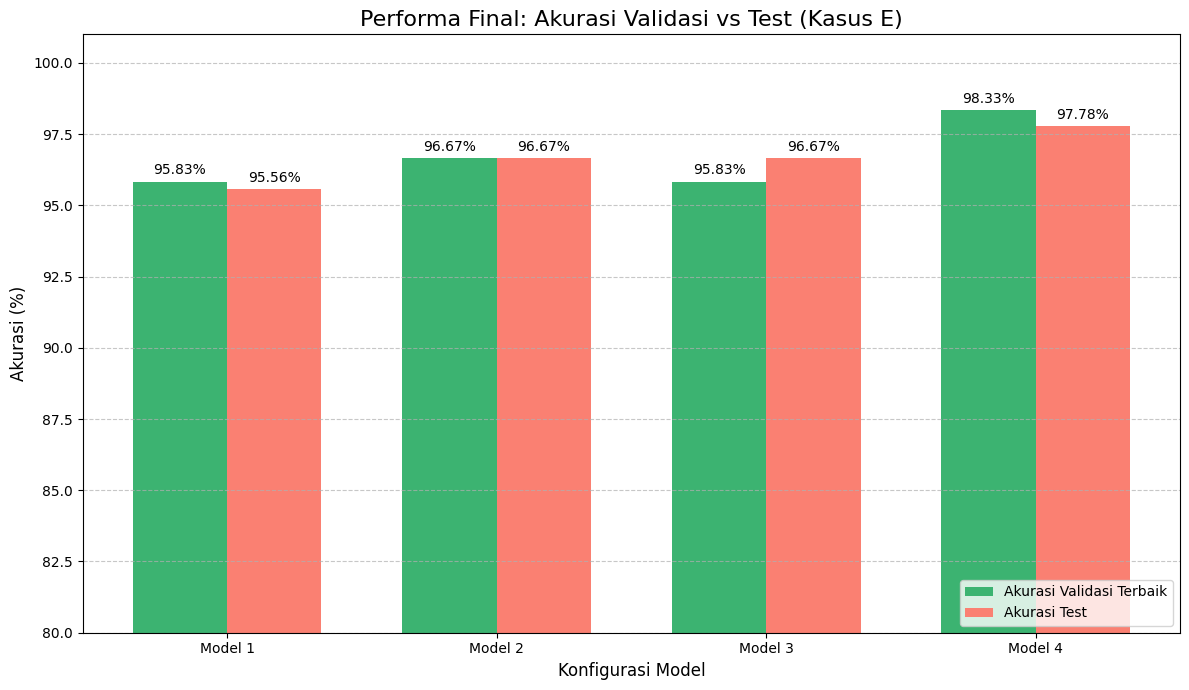

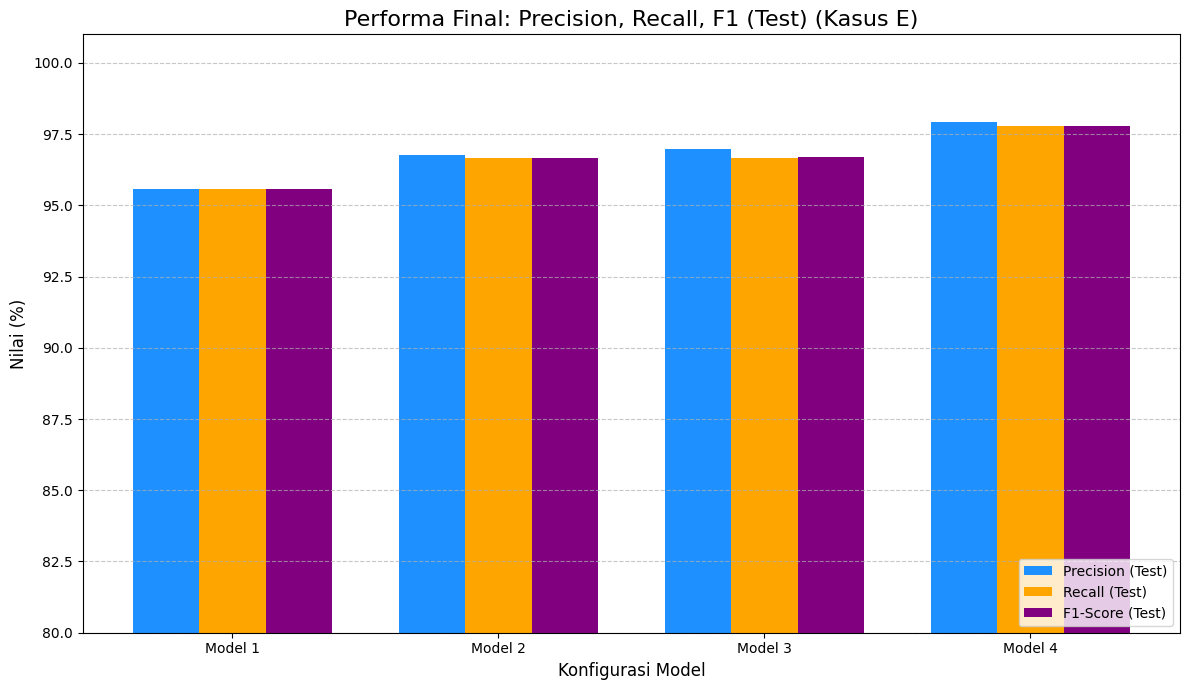


🏁 Visualisasi Kasus E selesai.



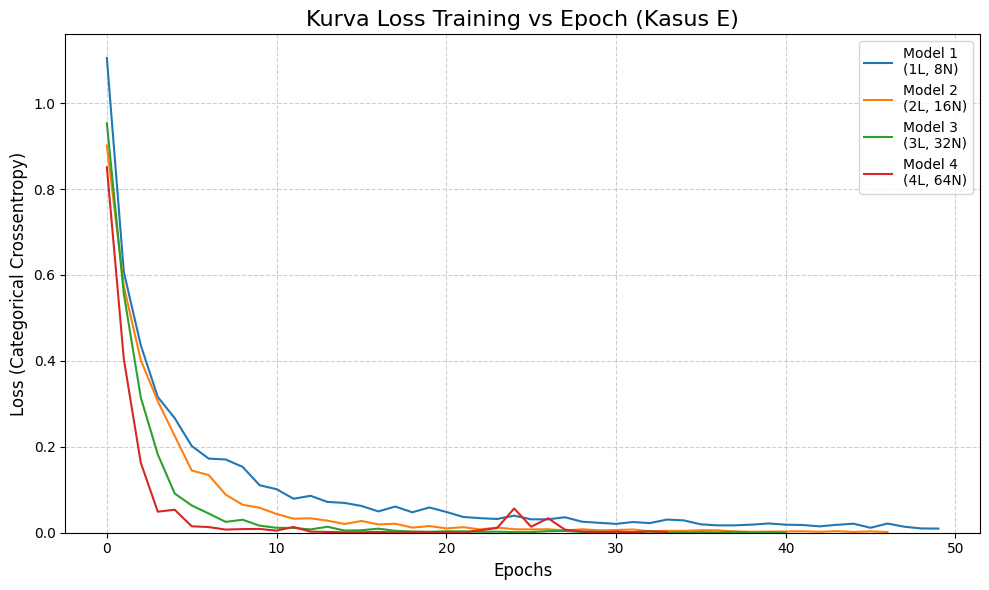

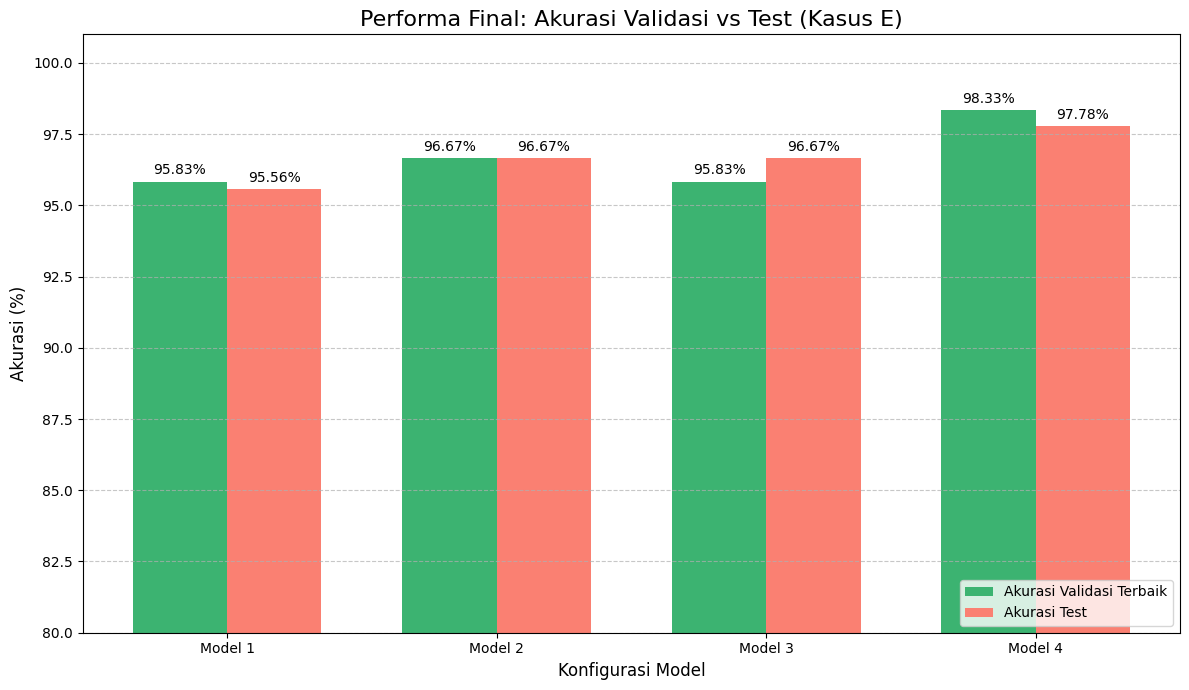

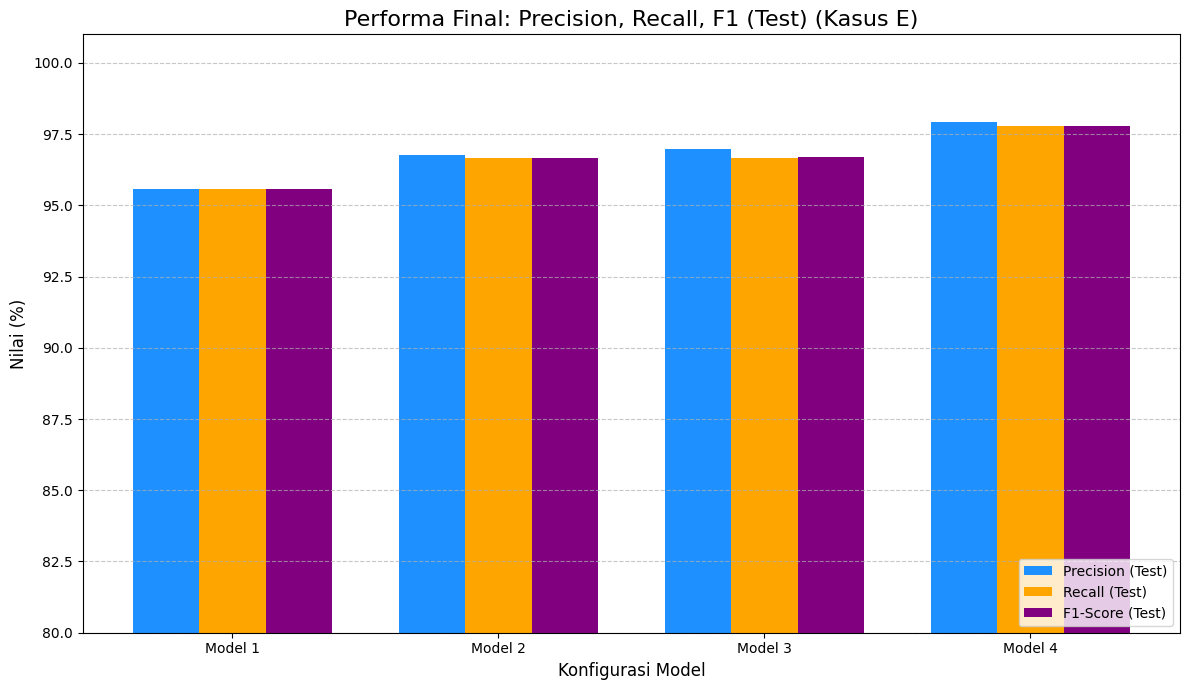


🏁 Visualisasi Kasus E selesai.



In [27]:
# ============================================================
# 5. VISUALISASI HASIL TRAINING (Kasus E)
# ============================================================
print("\n📊 Membuat 5 plot untuk menganalisis hasil Kasus E...\n")

import matplotlib.pyplot as plt
import numpy as np

# Label singkat untuk tiap model
short_labels = [f'Model {i+1}' for i in range(len(model_configs))]
x_pos = np.arange(len(short_labels))
width = 0.35

# ------------------------------------------------------------
# Plot 1: Epoch Terbaik (early stopping)
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
bars_epoch = plt.bar(short_labels, all_best_epochs, color='skyblue')
plt.title('Efisiensi Training: Epoch Terbaik per Model (Kasus E)', fontsize=16)
plt.ylabel('Jumlah Epoch', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar_label(bars_epoch, padding=3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 2: Kurva Loss Test vs Epoch
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for i, history in enumerate(all_test_loss_histories):
        plt.plot(history, label=model_labels[i])
plt.title('Kurva Loss Test vs Epoch (Kasus E)', fontsize=16)
plt.ylabel('Loss (Categorical Crossentropy)', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 3: Kurva Loss Training vs Epoch
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for i, history in enumerate(all_train_loss_histories):
        plt.plot(history, label=model_labels[i])
plt.title('Kurva Loss Training vs Epoch (Kasus E)', fontsize=16)
plt.ylabel('Loss (Categorical Crossentropy)', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 4: Perbandingan Akurasi Validasi vs Test
# ------------------------------------------------------------
plt.figure(figsize=(12, 7))
rects1 = plt.bar(x_pos - width/2, [acc * 100 for acc in all_best_val_accuracies],
                                 width, label='Akurasi Validasi Terbaik', color='mediumseagreen')
rects2 = plt.bar(x_pos + width/2, [acc * 100 for acc in all_test_accuracies],
                                 width, label='Akurasi Test', color='salmon')

plt.title('Performa Final: Akurasi Validasi vs Test (Kasus E)', fontsize=16)
plt.ylabel('Akurasi (%)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend(loc='lower right')
plt.bar_label(rects1, padding=3, fmt='%.2f%%')
plt.bar_label(rects2, padding=3, fmt='%.2f%%')
plt.ylim(80, 101)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 5: Precision / Recall / F1 (Test)
# ------------------------------------------------------------
plt.figure(figsize=(12, 7))
bar_width = 0.25
plt.bar(x_pos - bar_width, [p * 100 for p in all_precisions],
                bar_width, label='Precision (Test)', color='dodgerblue')
plt.bar(x_pos, [r * 100 for r in all_recalls],
                bar_width, label='Recall (Test)', color='orange')
plt.bar(x_pos + bar_width, [f * 100 for f in all_f1s],
                bar_width, label='F1-Score (Test)', color='purple')

plt.title('Performa Final: Precision, Recall, F1 (Test) (Kasus E)', fontsize=16)
plt.ylabel('Nilai (%)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend(loc='lower right')
plt.ylim(80, 101)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n🏁 Visualisasi Kasus E selesai.\n")

# ------------------------------------------------------------
# Plot 3: Kurva Loss Training vs Epoch
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for i, history in enumerate(all_train_loss_histories):
    plt.plot(history, label=model_labels[i])
plt.title('Kurva Loss Training vs Epoch (Kasus E)', fontsize=16)
plt.ylabel('Loss (Categorical Crossentropy)', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 4: Perbandingan Akurasi Validasi vs Test
# ------------------------------------------------------------
plt.figure(figsize=(12, 7))
rects1 = plt.bar(x_pos - width/2, [acc * 100 for acc in all_best_val_accuracies],
                 width, label='Akurasi Validasi Terbaik', color='mediumseagreen')
rects2 = plt.bar(x_pos + width/2, [acc * 100 for acc in all_test_accuracies],
                 width, label='Akurasi Test', color='salmon')

plt.title('Performa Final: Akurasi Validasi vs Test (Kasus E)', fontsize=16)
plt.ylabel('Akurasi (%)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend(loc='lower right')
plt.bar_label(rects1, padding=3, fmt='%.2f%%')
plt.bar_label(rects2, padding=3, fmt='%.2f%%')
plt.ylim(80, 101)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 5: Precision / Recall / F1 (Test)
# ------------------------------------------------------------
plt.figure(figsize=(12, 7))
bar_width = 0.25
plt.bar(x_pos - bar_width, [p * 100 for p in all_precisions],
        bar_width, label='Precision (Test)', color='dodgerblue')
plt.bar(x_pos, [r * 100 for r in all_recalls],
        bar_width, label='Recall (Test)', color='orange')
plt.bar(x_pos + bar_width, [f * 100 for f in all_f1s],
        bar_width, label='F1-Score (Test)', color='purple')

plt.title('Performa Final: Precision, Recall, F1 (Test) (Kasus E)', fontsize=16)
plt.ylabel('Nilai (%)', fontsize=12)
plt.xlabel('Konfigurasi Model', fontsize=12)
plt.xticks(x_pos, short_labels)
plt.legend(loc='lower right')
plt.ylim(80, 101)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n🏁 Visualisasi Kasus E selesai.\n")
